In [2]:
import tensorflow as tf
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  0


In [8]:
# model =  tf.keras.models.load_model("model_tire.h5")
# model =  tf.keras.models.load_model("model_tire_dense.h5")

model =  tf.keras.models.load_model("../models/resnet50.h5", compile=False)
# model =  tf.keras.models.load_model("./models/EfficientNetB0.h5", compile=False)

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['acc'])
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 random_flip_2 (RandomFlip)  (None, 256, 256, 3)       0         
                                                                 
 random_rotation_2 (RandomRo  (None, 256, 256, 3)      0         
 tation)                                                         
                                                                 
 random_height_2 (RandomHeig  (None, 256, 256, 3)      0         
 ht)                                                             
                                                                 
 random_width_2 (RandomWidth  (None, 256, 256, 3)      0         
 )                                                               
                                                                 
 resizing_2 (Resizing)       (None, 256, 256, 3)       0         
                                                      

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


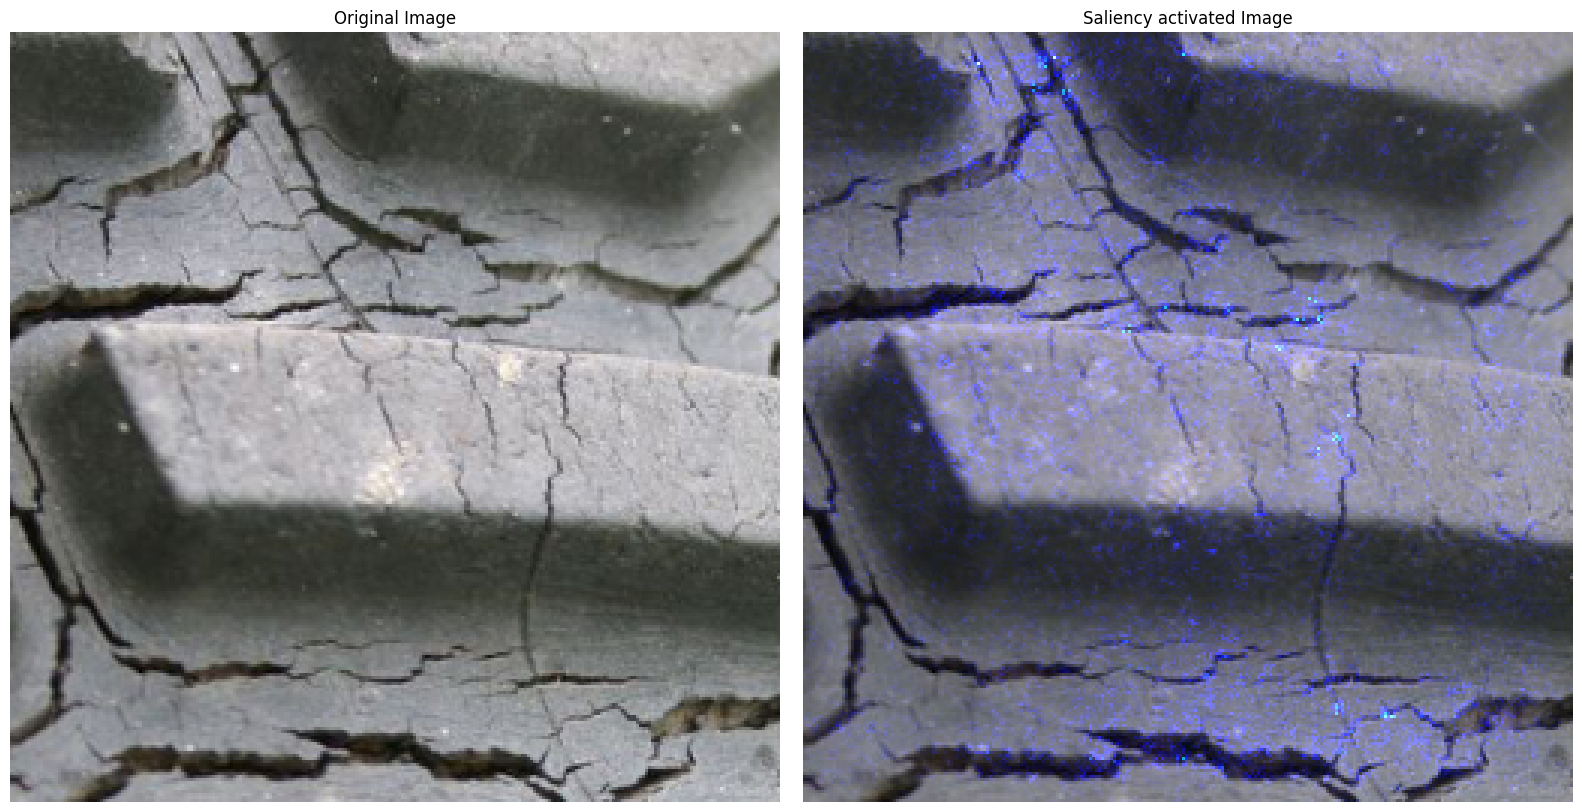

In [12]:
# read the image
# img = cv2.imread('./data/tire-dataset/flat.class/00150.jpg')
img = cv2.imread('.../../data/source/defective/Defective (7).jpg')
class_index = 1

num_classes = 2

# format it to be in the RGB colorspace
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) 

# resize to 300x300 and normalize pixel values to be in the range [0, 1]
img = cv2.resize(img, (256, 256)) / 255.0

# add a batch dimension in front
image = np.expand_dims(img, axis=0)

# convert to one hot representation to match our softmax activation in the model definition
expected_output = tf.one_hot([class_index] * image.shape[0], num_classes)

with tf.GradientTape() as tape:
    # cast image to float
    inputs = tf.cast(image, tf.float32)

    # watch the input pixels
    tape.watch(inputs)

    # generate the predictions
    predictions = model(inputs)

    # get the loss
    loss = tf.keras.losses.categorical_crossentropy(
        expected_output, predictions
    )

# get the gradient with respect to the inputs
gradients = tape.gradient(loss, inputs)
grayscale_tensor = tf.reduce_sum(tf.abs(gradients), axis=-1)

normalized_tensor = tf.cast(
    255
    * (grayscale_tensor - tf.reduce_min(grayscale_tensor))
    / (tf.reduce_max(grayscale_tensor) - tf.reduce_min(grayscale_tensor)),
    tf.uint8,
)

# remove the channel dimension to make the tensor a 2d tensor
normalized_tensor = tf.squeeze(normalized_tensor)
gradient_color = cv2.applyColorMap(normalized_tensor.numpy(), cv2.COLORMAP_HOT)
gradient_color = gradient_color / 255.0
super_imposed = cv2.addWeighted(img, 0.8, gradient_color, 0.8, 0.0)

fig, axes = plt.subplots(1, 2, figsize=(16, 8))

# Plot the first image in the first subplot
axes[0].imshow(img)
axes[0].axis('off')
axes[0].set_title('Original Image')  

# Plot the second image in the second subplot
axes[1].imshow(super_imposed)
axes[1].axis('off')
axes[1].set_title('Saliency activated Image')

# Adjust layout for better spacing
plt.tight_layout()

# Show the plot
plt.show()